# Example Usage & Plotting

In [1]:
import numpy as np
import gseapy
from scipy.sparse import csr_matrix
from tqdm.contrib.concurrent import process_map
from functools import partial
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import seaborn as sns
import numba as nb
from sklearn.manifold import SpectralEmbedding
import networkx
import pandas as pd
import random
import networkx

from geneclusters.cluster_genes_new import plot_component, plot_edges, plot_nodes, plot_single_cluster, group, compute_groupped_matrix, get_scores, find_similar_clusters, get_representative_name_per_cluster, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite

## Choose initiation

In [48]:
p = './examples/GO_Biological_Process_2023.npy'
mat = get_gene_pathway_matrix(p)
N = 1000

mmap_1 = './examples/GO_Biological_Process_2023_labels_30.npy'
mmap_2 = './examples/GO_Biological_Process_2023_losses_30.npy'

mode = 'r'

labels = np.lib.format.open_memmap(mmap_1, shape=(N, sum(mat.shape)), dtype=int, mode=mode)
losses = np.lib.format.open_memmap(mmap_2, shape=(1, N), dtype=int, mode=mode)

labeling = labels[np.argmin(losses[0])]
matrix = np.ascontiguousarray(mat.values.T)
pathway_names = mat.index
gene_names = mat.columns
frame = pd.DataFrame(labeling)
frame['description'] = np.concatenate([gene_names, pathway_names])
frame['is_gene'] = np.arange(frame.shape[0]) < matrix.shape[0]

In [49]:
frame.columns = ['cluster', 'description', 'is_gene']

In [50]:
frame.head()

,cluster,description,is_gene
0,544,A4GNT,True
1,632,AAK1,True
2,128,AARS1,True
3,189,AARS2,True
4,441,AASDHPPT,True


# Cluster merging

In [51]:
matrix = np.array(mat)
cols = np.array(frame[frame['is_gene']]['cluster'])
rows = np.array(frame[np.invert(frame['is_gene'])]['cluster'])

In [52]:
# merge clusters that fall within certain threshold
groupped_matrix, mapping = compute_groupped_matrix(matrix, cols, rows)
to_merge = find_similar_clusters(groupped_matrix)
inverse_mapping = {v: k for (k, v) in mapping.items()}
to_merge_remapped = {inverse_mapping[k]: inverse_mapping[v] for (k, v) in to_merge.items()}
update_mapping = np.vectorize(lambda x: to_merge_remapped.get(x, x))
new_cols = update_mapping(cols)
new_rows = update_mapping(rows)
groupped_matrix_new, mapping = compute_groupped_matrix(matrix, new_cols, new_rows)

In [53]:
frame['new_cluster'] = np.concatenate((new_cols, new_rows))

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


671
668


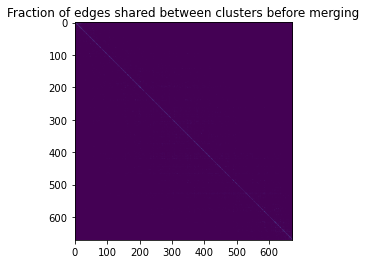

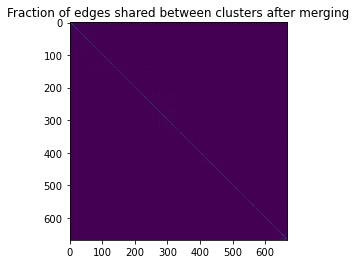

In [54]:
# plot pre and post merge heatmaps
# inspect the pre-merge heatmap to see if any clusters need to be merged
# specify the threshold accordingly 

embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
X_transformed_new = embedding.fit_transform(groupped_matrix_new)
X_transformed = embedding.fit_transform(groupped_matrix)

o = np.argsort(X_transformed.ravel())
plt.imshow((groupped_matrix[o][:,o]))
plt.title('Fraction of edges shared between clusters before merging')

plt.figure()
o = np.argsort(X_transformed_new.ravel())
plt.imshow((groupped_matrix_new[o][:,o]))
plt.title('Fraction of edges shared between clusters after merging')

print(X_transformed.shape[0])
print(X_transformed_new.shape[0])

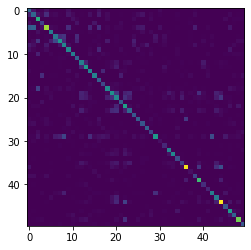

In [60]:
plt.imshow((groupped_matrix_new[o][:,o][:50,:50]))


In [65]:
frame.to_csv('./examples/GO_Biological_Process_2023_30_frame.csv')

# Assign represenative names

In [63]:
mat = get_gene_pathway_matrix(p)
colnames = np.array(mat.columns)
rownames = np.array(mat.index)

out = [get_representative_name_per_cluster(np.array(mat), colnames, rownames, frame, x) for x in np.unique(frame['new_cluster'])]
names = pd.DataFrame(out)
names.columns = ['cluster_ID', 'representative_pathway', 'fraction_internal_connections', 'N_internal_connections']


In [64]:
names.to_csv('./examples/GO_Biological_Process_2023_30_names.csv')

In [66]:
names.head()

,cluster_ID,representative_pathway,fraction_internal_connections,N_internal_connections
0,C.0,Zymogen Inhibition,0.600000,3.0
1,C.1,ATP Synthesis Coupled Electron Transport,0.714286,5.0
2,C.2,Phosphatidylinositol Dephosphorylation,0.750000,12.0
3,C.3,L-fucose Catabolic Process,0.750000,6.0
4,C.4,Positive Regulation Of Phospholipid Biosynthet...,0.500000,3.0


# Plotting

In [3]:
# need to play around with the k (should reflect the grouped matrix ordered by spectral embedding)

# load data
path = './examples/HumanCyc_2016.npy'
data = pd.read_csv('./examples/kl_example_merged.csv')
mat = (get_gene_pathway_matrix(path))

In [4]:
# making some random selections here, but could be visualizing only the clusters with evidence for perturbation etc..
clust_sele = random.sample(set(data['new_cluster']), k=10)

# get corresponding gene and pathway info for the selected clusters
index = [x in clust_sele for x in data['new_cluster']]
genes = data[index].loc[data['is_gene']]
paths = data[index].loc[np.invert(data['is_gene'])]
matrix = np.array(mat.loc[(paths['description'])].loc[:,genes['description']])
rows = np.array(paths['new_cluster'])
cols = np.array(genes['new_cluster'])

# selecting some random names, but could be genes of interest (e.g. with evidence for change in condition)
selected_names = random.sample(set(genes['description']), 50)


In [5]:
# set up the graph
N = len(rows) + len(cols)
full_matrix = np.zeros((N, N), dtype=matrix.dtype)
full_matrix[:matrix.shape[0],matrix.shape[0]:] = matrix
graph = networkx.from_numpy_array(full_matrix)
cluster_labels = np.concatenate([rows, cols])
node_names = np.concatenate([paths['description'], genes['description']])
for i, l in enumerate(cluster_labels):
    graph.nodes[i]['cluster_id'] = l
    graph.nodes[i]['type'] = i < matrix.shape[0]
    graph.nodes[i]['name'] = node_names[i]
    
for e_i in range(N):
    for e_j in range(e_i + 1, N):
        if graph.nodes[e_i]['cluster_id'] == graph.nodes[e_j]['cluster_id'] and not graph.has_edge(e_i, e_j):
            graph.add_edge(e_i, e_j, weight=0.05)
            
components = list(networkx.connected_components(graph))
unique_clusters = np.unique(np.array([graph.nodes[node]['cluster_id'] for node in graph.nodes]))

# get colors
cm = plt.cm.get_cmap('tab20')
colors = [cm(int(x)) for x in range(len(unique_clusters))]

In [14]:
len(components)

3

Text(0.5, 1.0, 'Example 1')

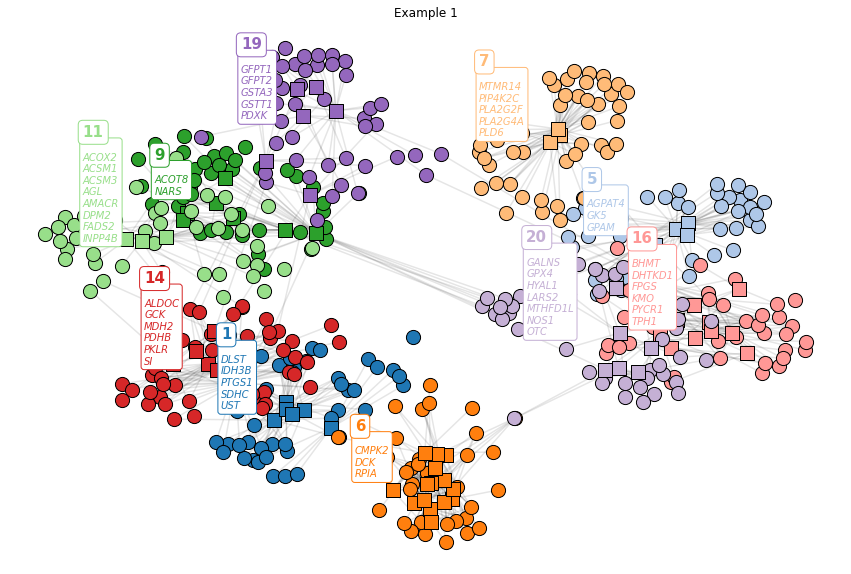

In [13]:
# Plot components all at once

plt.figure(figsize = (15, 10))
seed = 5
plot_component(graph, selected_names, unique_clusters, colors, k=40, iterations=10000, scale=1, component = None, center=None, seed=None)

a = plt.gca()
a.axis('off')
plt.title('Example 1')


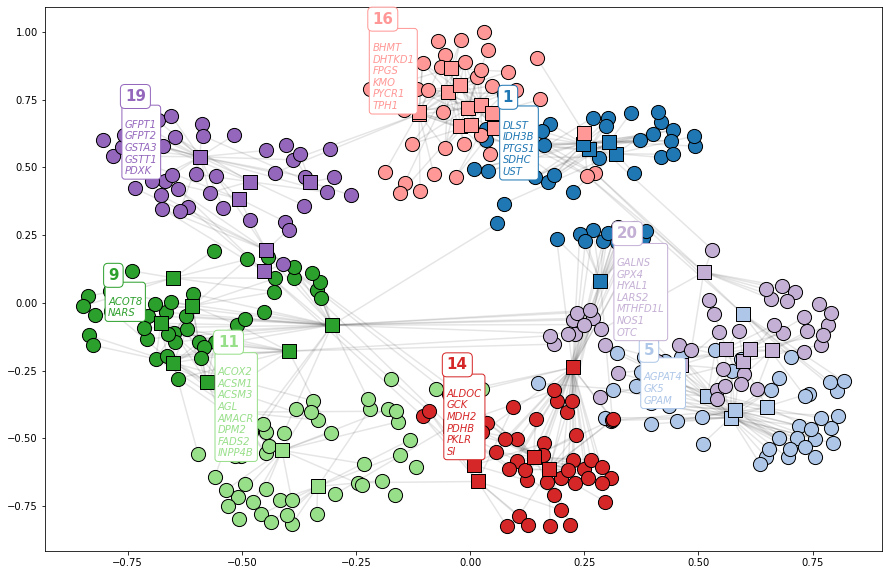

In [16]:
# Plot separate components individually
plt.figure(figsize = (15, 10))
seed = 5

plot_component(graph, selected_names, unique_clusters, colors, k=40, iterations=10000, scale=1, component = components[np.argmax([len(x) for x in components])], center=None, seed=None)


In [ ]:
#### check new stuff w G
#### add disconnected code --> to assign nodes to different cluster if they don't share a single edge with the current cluster assignment
#### discuss individual component plotting
#### Add code to run multiple iterations on cluster to get best solution for GO 
#### Show this plotting in separate notebook (also with times - how long took to compute with the given resources)
#### update README
#### mssg jose